<a href="https://colab.research.google.com/github/sohamtalukdar/Segmentation-of-Kidneys-in-MRI/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
#tf. test. gpu_device_name()
# !sudo apt-get update -y
# !sudo apt-get install python3.9
!python --version
#!nvidia-smi -q
tf.__version__

Python 3.7.13


'2.8.2'

In [2]:
!pip install nibabel --upgrade
#!pip install keras-unet-collection==0.1.13
#!pip install keras-adabound
#!pip install focal-loss
#pip install segmentation_models_3D
#from keras_unet_collection import models
#from keras_adabound import AdaBound
import scipy.ndimage as ndi
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import nibabel as nib
from nibabel.processing import conform
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, Nadam,RMSprop
import random
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from keras import backend as K
from PIL import ImageOps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 5.1 MB/s 
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
"""Shamelessly taken from Alex Daniel - will cite properly!"""

def rescale(data, black=None, white=None):
    if black is None:
        black = np.mean(data) - 0.5 * np.std(data)
        if black < data.min():
            black = data.min()
    if white is None:
        white = np.mean(data) + 4 * np.std(data)
        if white > data.max():
            white = data.max()
    data = np.clip(data, black, white) - black
    data = data / (white - black)
    return data

def normalise_image(image, affine):

    image = rescale(image)
    img = nib.Nifti1Image(image, affine)
    zoom = img.header.get_zooms()
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, zoom[-1] * 0.998),
                  orientation='LIP')
    image = img.get_fdata()
    image = resize(image, (256, 256, image.shape[2]))
    zoom = img.header.get_zooms()
    return image
  
def normalise_mask(mask, affine):

    img = nib.Nifti1Image(mask, affine)
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, img.header.get_zooms()[-1] *
                              0.998),
                  orientation='LIP')
    mask = img.get_fdata()
    mask = resize(mask, (256, 256, mask.shape[2]))
    mask = np.round(mask)
    return mask

In [5]:
ground_truths = []
base_scans = []
dir = '/content/drive/MyDrive/ColabNotebooks/UNet/'
for f in sorted(os.listdir(dir + 'GroundTruth/')):
  image = nib.load(dir + 'GroundTruth/' + f)
  ground_truths.append(image)
for f in sorted(os.listdir(dir + 'Masks_T1/')):
  image = nib.load(dir + 'Masks_T1/'+ f)
  base_scans.append(image)
print(ground_truths[1].header.get_data_shape())


(256, 256, 17)


In [6]:
gt_arrays = []
gt_affine = []
base_arrays = []
base_affine = []
for img in ground_truths:
  affine = img.affine
  gt_voxels = img.get_fdata()
  normalised = normalise_mask(gt_voxels, affine)
  gt_arrays.append(normalised)
for img in base_scans:
  affine = img.affine
  base_voxels = img.get_fdata()
  normalised = normalise_image(base_voxels, affine)
  base_arrays.append(base_voxels)
pairs = zip(gt_arrays, base_arrays)

print(gt_arrays[1].shape)
print(len(gt_arrays), len(gt_affine))
print(type(base_arrays[2]))




(256, 256, 17)
10 0
<class 'numpy.ndarray'>


In [7]:
x_series = pd.Series(base_arrays)
y_series = pd.Series(gt_arrays)

#also courtesy of Alex Daniel

def tf_arrays(series):
    data = np.concatenate(series, 2)
    data = np.swapaxes(data, 0, 2)
    data = np.swapaxes(data, 1, 2)
    data = np.expand_dims(data, 3)
    return data

x_data = tf_arrays(x_series)
y_data = tf_arrays(y_series)
"""
for img in base_arrays:
  for i in range(0,17):
    x_images.append(img[:,:,i,np.newaxis])
for img in gt_arrays:
  for i in range(0,17):
    y_images.append(img[:,:,i,np.newaxis])
"""

print(len(x_data), len(y_data))
print(x_data[1].shape, y_data[1].shape)


"""
fig, ax = plt.subplots(2)
ax[0].imshow(x_images[46])
ax[1].imshow(y_images[46])
plt.show()
"""

170 170
(256, 256, 1) (256, 256, 1)


'\nfig, ax = plt.subplots(2)\nax[0].imshow(x_images[46])\nax[1].imshow(y_images[46])\nplt.show()\n'

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size = 0.2)

In [234]:
### UNET

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2



def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1


def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model


In [235]:
input_shape = (256, 256,1)
model = U_Net(input_shape)

In [236]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[0, 1])
    union = K.sum(y_true, axis=[0,1]) + K.sum(y_pred, axis=[0, 1])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
  return 1 - dice_coefficient(y_true, y_pred)

In [237]:
model.compile(optimizer= Adam(learning_rate = 1e-4), 
              loss= 'sparse_categorical_crossentropy',
              metrics = ['accuracy',dice_coefficient]
              )

In [239]:
history = model.fit(x=x_train, 
                   y=y_train, 
                   batch_size=2, 
                   steps_per_epoch=len(x_train)//2,
                   epochs=1, 
                   validation_data=(x_valid, y_valid), 
                   )

68/68 [==============================] - 6s 87ms/step - loss: 0.1831 - accuracy: 0.9851 - dice_coefficient: 0.0883 - val_loss: 0.2733 - val_accuracy: 0.9817 - val_dice_coefficient: 0.0784


In [240]:
model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_valid)

2/2 [==============================] - 1s 29ms/step - loss: 0.2733 - accuracy: 0.9817 - dice_coefficient: 0.0971


In [264]:
from keras.metrics import MeanIoU
num_classes = 3
IOU = MeanIoU(num_classes=num_classes)  
IOU.update_state(y_valid, np.argmax(predicted_masks, axis =3))
print("Mean IoU = ", IOU.result().numpy())

Mean IoU =  0.55205685


In [260]:
from keras.metrics import MeanIoU
num_classes = 3
for i in range(len(x_valid)):
  IOU = MeanIoU(num_classes=num_classes)  
  IOU.update_state(y_valid[i], np.argmax(predicted_masks[i], axis =2))
  print(f"Mean IoU for slices {i} = ", IOU.result().numpy())

Mean IoU for slices 0 =  1.0
Mean IoU for slices 1 =  0.56983197
Mean IoU for slices 2 =  0.45419943
Mean IoU for slices 3 =  0.57276016
Mean IoU for slices 4 =  0.6654658
Mean IoU for slices 5 =  0.5849817
Mean IoU for slices 6 =  0.4778904
Mean IoU for slices 7 =  1.0
Mean IoU for slices 8 =  0.5099893
Mean IoU for slices 9 =  1.0
Mean IoU for slices 10 =  0.4611411
Mean IoU for slices 11 =  0.6107115
Mean IoU for slices 12 =  0.45071885
Mean IoU for slices 13 =  0.57121545
Mean IoU for slices 14 =  1.0
Mean IoU for slices 15 =  0.47856638
Mean IoU for slices 16 =  0.6186053
Mean IoU for slices 17 =  0.65253633
Mean IoU for slices 18 =  0.6127607
Mean IoU for slices 19 =  0.48775637
Mean IoU for slices 20 =  1.0
Mean IoU for slices 21 =  1.0
Mean IoU for slices 22 =  1.0
Mean IoU for slices 23 =  0.52762747
Mean IoU for slices 24 =  1.0
Mean IoU for slices 25 =  1.0
Mean IoU for slices 26 =  0.50356185
Mean IoU for slices 27 =  1.0
Mean IoU for slices 28 =  0.49315497
Mean IoU for sl

In [233]:
values = np.array(IOU.get_weights()).reshape(num_classes, num_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] +  values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] +  values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[2.109758e+06 3.047300e+04 2.350200e+04]
 [1.052000e+03 4.421800e+04 1.492000e+03]
 [5.000000e+00 1.724400e+04 4.800000e+02]]
IoU for class1 is:  0.9745786
IoU for class2 is:  0.46801934
IoU for class3 is:  0.011235166


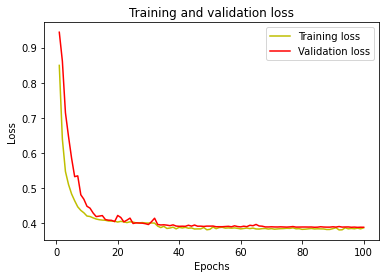

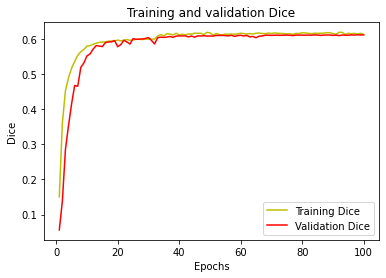

In [159]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

2/2 [==============================] - 1s 32ms/step - loss: 0.4266 - accuracy: 0.0087 - dice_coefficient: 0.5829


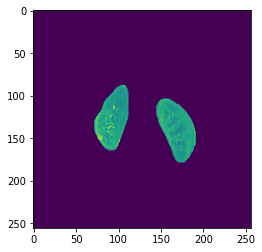

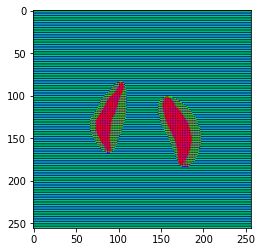

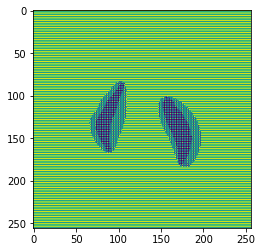

In [160]:
model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_train)
plt.show()
#for i in range(0,len(x_valid)):
i = 12
plt.imshow(ndi.rotate(np.squeeze(x_train[i]),-90))
plt.show()
# plt.imshow(np.squeeze(y_train[i]))
# plt.show()
plt.imshow(ndi.rotate(np.squeeze(predicted_masks[i]),-90))
plt.show()


def display_mask(j):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(predicted_masks[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    #display(img)
    plt.imshow(ndi.rotate(np.squeeze(mask),-90))
    plt.show()


display_mask(predicted_masks[i])



In [ ]:
y_pred=model.predict(x_valid)
y_pred_argmax=np.argmax(y_pred, axis=2)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_valid[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

# plt.imshow(x_train[0, :,:,0], cmap='gray')
# plt.imshow(train_masks[0], cmap='gray')
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(x_valid))
test_img = x_valid[test_img_number]
ground_truth=y_valid[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()
